# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(ATT_IMPUTED_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_IMPUTED_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
OUTPUT_SIZE = labels_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 400
LEARNING_RATE = 0.001
BATCH_SIZE = 128
ACTIVATION = "tanh"
N_HIDDEN = [128, 64, 32]
REGULARIZER = keras.regularizers.l2(0.001)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name


def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = architecture2()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/400
101/101 [==============================] - 2s 6ms/step - loss: 1.4713 - categorical_accuracy: 0.6183 - val_loss: 0.9115 - val_categorical_accuracy: 0.7146
Epoch 2/400
101/101 [==============================] - 0s 5ms/step - loss: 1.0627 - categorical_accuracy: 0.6617 - val_loss: 0.9627 - val_categorical_accuracy: 0.6904
Epoch 3/400
101/101 [==============================] - 0s 5ms/step - loss: 1.0154 - categorical_accuracy: 0.6727 - val_loss: 0.9836 - val_categorical_accuracy: 0.6563
Epoch 4/400
101/101 [==============================] - 0s 5ms/step - loss: 1.0720 - categorical_accuracy: 0.6646 - val_loss: 1.2689 - val_categorical_accuracy: 0.6632
Epoch 5/400
101/101 [==============================] - 0s 5ms/step - loss: 0.9776 - categorical_accuracy: 0.6871 - val_loss: 1.0245 - val_categorical_accuracy: 0.6737
Epoch 6/400
101/101 [==============================] - 0s 5ms/step - loss: 1.0366 - categorical_accuracy: 0.6785 - val_loss: 1.1777 - val_categorical_accuracy: 0.622

Epoch 50/400
101/101 [==============================] - 1s 7ms/step - loss: 1.8920 - categorical_accuracy: 0.4198 - val_loss: 1.7945 - val_categorical_accuracy: 0.4311
Epoch 51/400
101/101 [==============================] - 1s 6ms/step - loss: 1.8384 - categorical_accuracy: 0.4189 - val_loss: 1.7046 - val_categorical_accuracy: 0.3797
Epoch 52/400
101/101 [==============================] - 1s 6ms/step - loss: 1.5755 - categorical_accuracy: 0.4310 - val_loss: 2.1347 - val_categorical_accuracy: 0.3598
Epoch 53/400
101/101 [==============================] - 1s 6ms/step - loss: 1.7439 - categorical_accuracy: 0.4820 - val_loss: 1.5888 - val_categorical_accuracy: 0.3381
Epoch 54/400
101/101 [==============================] - 1s 6ms/step - loss: 1.3968 - categorical_accuracy: 0.4745 - val_loss: 1.3314 - val_categorical_accuracy: 0.4950
Epoch 55/400
101/101 [==============================] - 1s 6ms/step - loss: 1.6007 - categorical_accuracy: 0.4939 - val_loss: 1.7407 - val_categorical_accuracy:

Epoch 99/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4355 - categorical_accuracy: 0.2490 - val_loss: 1.5579 - val_categorical_accuracy: 0.2816
Epoch 100/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4460 - categorical_accuracy: 0.2573 - val_loss: 1.4404 - val_categorical_accuracy: 0.2717
Epoch 101/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4455 - categorical_accuracy: 0.2479 - val_loss: 1.4591 - val_categorical_accuracy: 0.2128
Epoch 102/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4519 - categorical_accuracy: 0.2530 - val_loss: 1.4095 - val_categorical_accuracy: 0.2816
Epoch 103/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4690 - categorical_accuracy: 0.2491 - val_loss: 1.4986 - val_categorical_accuracy: 0.2717
Epoch 104/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4341 - categorical_accuracy: 0.2526 - val_loss: 1.4908 - val_categorical_accu

101/101 [==============================] - 1s 7ms/step - loss: 1.5544 - categorical_accuracy: 0.2511 - val_loss: 1.4808 - val_categorical_accuracy: 0.2816
Epoch 148/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4684 - categorical_accuracy: 0.2506 - val_loss: 1.4706 - val_categorical_accuracy: 0.2717
Epoch 149/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4250 - categorical_accuracy: 0.2504 - val_loss: 1.4158 - val_categorical_accuracy: 0.2339
Epoch 150/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4253 - categorical_accuracy: 0.2534 - val_loss: 1.4403 - val_categorical_accuracy: 0.2128
Epoch 151/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4862 - categorical_accuracy: 0.2508 - val_loss: 1.4170 - val_categorical_accuracy: 0.2816
Epoch 152/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4325 - categorical_accuracy: 0.2570 - val_loss: 1.4455 - val_categorical_accuracy: 0.2339


101/101 [==============================] - 1s 7ms/step - loss: 1.4203 - categorical_accuracy: 0.2510 - val_loss: 1.3925 - val_categorical_accuracy: 0.2339
Epoch 196/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4267 - categorical_accuracy: 0.2477 - val_loss: 1.4641 - val_categorical_accuracy: 0.2339
Epoch 197/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4418 - categorical_accuracy: 0.2549 - val_loss: 1.4461 - val_categorical_accuracy: 0.2339
Epoch 198/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4422 - categorical_accuracy: 0.2469 - val_loss: 1.4379 - val_categorical_accuracy: 0.2816
Epoch 199/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4466 - categorical_accuracy: 0.2535 - val_loss: 1.3880 - val_categorical_accuracy: 0.2128
Epoch 200/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4380 - categorical_accuracy: 0.2542 - val_loss: 1.4476 - val_categorical_accuracy: 0.2816


101/101 [==============================] - 1s 6ms/step - loss: 1.5416 - categorical_accuracy: 0.2498 - val_loss: 1.4154 - val_categorical_accuracy: 0.2339
Epoch 244/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4486 - categorical_accuracy: 0.2527 - val_loss: 1.4834 - val_categorical_accuracy: 0.2339
Epoch 245/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4665 - categorical_accuracy: 0.2614 - val_loss: 1.4007 - val_categorical_accuracy: 0.2816
Epoch 246/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4253 - categorical_accuracy: 0.2553 - val_loss: 1.5235 - val_categorical_accuracy: 0.2339
Epoch 247/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4219 - categorical_accuracy: 0.2506 - val_loss: 1.4115 - val_categorical_accuracy: 0.2128
Epoch 248/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4576 - categorical_accuracy: 0.2603 - val_loss: 1.4626 - val_categorical_accuracy: 0.2816


101/101 [==============================] - 1s 6ms/step - loss: 1.4698 - categorical_accuracy: 0.2579 - val_loss: 1.4642 - val_categorical_accuracy: 0.2717
Epoch 292/400
101/101 [==============================] - 1s 6ms/step - loss: 1.5039 - categorical_accuracy: 0.2573 - val_loss: 1.5290 - val_categorical_accuracy: 0.2816
Epoch 293/400
101/101 [==============================] - 1s 6ms/step - loss: 1.5133 - categorical_accuracy: 0.2486 - val_loss: 1.4108 - val_categorical_accuracy: 0.2816
Epoch 294/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4641 - categorical_accuracy: 0.2511 - val_loss: 1.4497 - val_categorical_accuracy: 0.2128
Epoch 295/400
101/101 [==============================] - 1s 6ms/step - loss: 1.8457 - categorical_accuracy: 0.2524 - val_loss: 2.2557 - val_categorical_accuracy: 0.2717
Epoch 296/400
101/101 [==============================] - 1s 6ms/step - loss: 1.5890 - categorical_accuracy: 0.2591 - val_loss: 1.4963 - val_categorical_accuracy: 0.2816


101/101 [==============================] - 1s 7ms/step - loss: 1.4789 - categorical_accuracy: 0.2591 - val_loss: 1.3945 - val_categorical_accuracy: 0.2128
Epoch 340/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4479 - categorical_accuracy: 0.2518 - val_loss: 1.3930 - val_categorical_accuracy: 0.2717
Epoch 341/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4188 - categorical_accuracy: 0.2612 - val_loss: 1.3867 - val_categorical_accuracy: 0.2717
Epoch 342/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4351 - categorical_accuracy: 0.2492 - val_loss: 1.4056 - val_categorical_accuracy: 0.2816
Epoch 343/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4422 - categorical_accuracy: 0.2525 - val_loss: 1.4337 - val_categorical_accuracy: 0.2717
Epoch 344/400
101/101 [==============================] - 1s 7ms/step - loss: 1.4497 - categorical_accuracy: 0.2559 - val_loss: 1.5152 - val_categorical_accuracy: 0.2128


101/101 [==============================] - 1s 6ms/step - loss: 1.5246 - categorical_accuracy: 0.2483 - val_loss: 1.4957 - val_categorical_accuracy: 0.2339
Epoch 388/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4713 - categorical_accuracy: 0.2519 - val_loss: 1.4670 - val_categorical_accuracy: 0.2128
Epoch 389/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4340 - categorical_accuracy: 0.2614 - val_loss: 1.4271 - val_categorical_accuracy: 0.2717
Epoch 390/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4458 - categorical_accuracy: 0.2549 - val_loss: 1.4189 - val_categorical_accuracy: 0.2717
Epoch 391/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4589 - categorical_accuracy: 0.2596 - val_loss: 1.4464 - val_categorical_accuracy: 0.2717
Epoch 392/400
101/101 [==============================] - 1s 6ms/step - loss: 1.4293 - categorical_accuracy: 0.2497 - val_loss: 1.4715 - val_categorical_accuracy: 0.2717


## Step 7: Analyze results

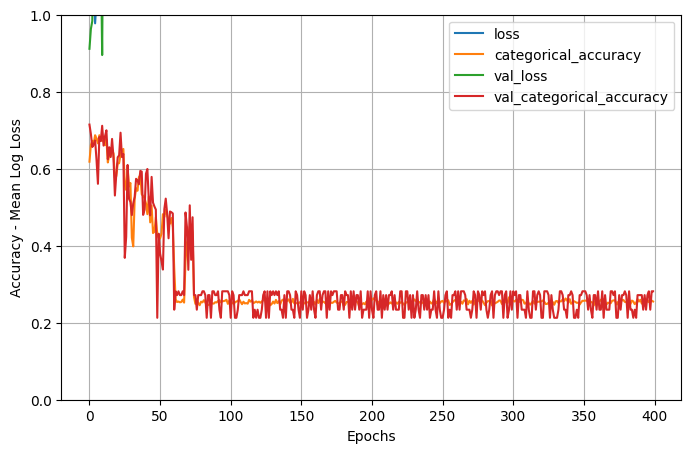

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Error (training): 74.49 %
Error (test): 71.84 %
Bias: 69.49
Variance: -2.65
Time:  261 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 2ms/step


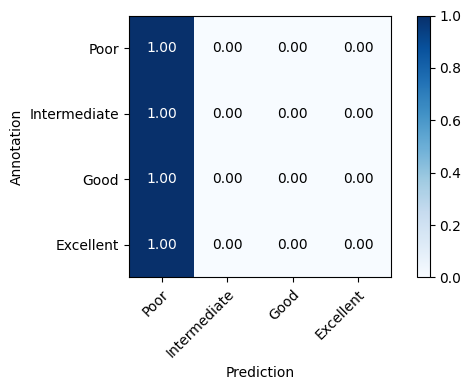

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [16]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "ADAM b109 b20999",
    "l2 0.001",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


In [18]:
last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

      model_name  epochs  learning_rate  batch_size activation  \
35  D128_D64_D32     400            0.1         128       tanh   
36  D128_D64_D32     400            0.1         128       tanh   
37  D128_D64_D32     400            0.1         128       tanh   
38  D128_D64_D32     400            0.1         128       tanh   
39  D128_D64_D32     400            0.1         128       tanh   

                        loss optimizer regularization  train_accuracy  \
35  categorical_crossentropy      ADAM       l2 0.001           24.83   
36  categorical_crossentropy      ADAM       l2 0.001           25.39   
37  categorical_crossentropy      ADAM       l2 0.001           25.51   
38  categorical_crossentropy      ADAM       l2 0.001           25.47   
39  categorical_crossentropy      ADAM       l2 0.001           25.51   

    validation_accuracy   bias  variance  training_time  
35                23.39  70.17      1.44            273  
36                28.16  69.61     -2.77        

In [19]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-4.h5"
my_model.save(save_name)